In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, pearsonr, spearmanr

from utils import *

In [2]:
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress
import os
import numpy as np
import pandas as pd

model_dir = "/Users/jessica.schmilovich/Documents/GSTEM Research Project/BehavioralModel-main/Fits"
behavior_dir = "/Users/jessica.schmilovich/Documents/GSTEM Research Project/BehVar-main/Rats"

rat_metrics = []

for fname in os.listdir(model_dir):
    if not fname.endswith(".mat"):
        continue

    rat_id = fname.replace("_Fits_NFoldCV.mat", "")
    mat_data = load_mat_file(os.path.join(model_dir, fname))
    bestfit_folds = mat_data["BestFit_Folds"]

    # Extract model parameters
    param_df = extract_bestfit_params(bestfit_folds)
    param_means = param_df.mean(numeric_only=True)

    kappa_mixed = param_means["param1"]
    kappa_high = param_means["param2"]
    kappa_low = param_means["param3"]
    lambd = param_means["param5"]

    # Load behavior file
    beh_name = f"ratTrial_{rat_id}.mat"
    beh_path = os.path.join(behavior_dir, beh_name)
    if not os.path.exists(beh_path):
        continue

    beh_df = load_behavior_data(beh_path)

    # reward sensitivity and block sensitivity
    _, block_ratio, reward_slope = calc_block_sensitivity_and_mixed_slope(beh_df)

    # opt-out threshold and slope using derivative logic
    optout_prob, bins = get_optout_probability_no_plot(beh_df)
    if np.all(np.isnan(optout_prob)):
        opt_thresh, opt_slope = np.nan, np.nan
    else:
        smoothed = gaussian_filter1d(optout_prob, sigma=1)
        d_optout = np.gradient(smoothed, bins)

        rise_indices = np.where(d_optout > 0.01)[0]
        if len(rise_indices) > 0:
            t = rise_indices[0]
            opt_thresh = bins[t]
            if t < len(bins) - 2:
                opt_slope = linregress(bins[t:], optout_prob[t:])[0]
            else:
                opt_slope = np.nan
        else:
            opt_thresh = np.nan
            opt_slope = np.nan

    rat_metrics.append({
        "rat": rat_id,
        "reward_sensitivity": reward_slope,
        "block_sensitivity": block_ratio,
        "lambda": lambd,
        "kappa_mixed_minus_kappa_high": kappa_mixed - kappa_high,
        "kappa_high_minus_kappa_mixed": kappa_high - kappa_mixed,
        "kappa_high_minus_kappa_low": kappa_high - kappa_low,
        "optout_threshold": opt_thresh,
        "optout_slope": opt_slope
    })

df = pd.DataFrame(rat_metrics)

# add lambda group by tertiles
tertiles = np.nanpercentile(df['lambda'], [33.3, 66.7])
def assign_lambda_group(val):
    if val <= tertiles[0]: return 'poor'
    elif val <= tertiles[1]: return 'medium'
    else: return 'good'
df['lambda_group'] = df['lambda'].apply(assign_lambda_group)

df.head()

,rat,reward_sensitivity,block_sensitivity,lambda,kappa_mixed_minus_kappa_high,kappa_high_minus_kappa_mixed,kappa_high_minus_kappa_low,optout_threshold,optout_slope,lambda_group
0,L010,1.212966,1.158374,0.838987,0.007291,-0.007291,0.029319,5.5,0.071475,good
1,J014,1.468032,1.140556,0.766177,-0.087656,0.087656,0.137930,3.5,0.079789,good
2,G055,1.344542,1.071326,0.686455,-0.132219,0.132219,0.121710,3.5,0.069940,good
3,S001,1.904888,1.148261,0.287376,0.336337,-0.336337,-0.019161,3.5,0.057125,poor
4,M054,1.301244,1.069361,0.490644,0.009475,-0.009475,-0.007273,4.0,0.091487,medium


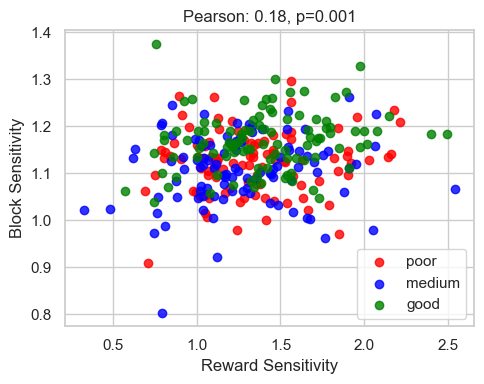

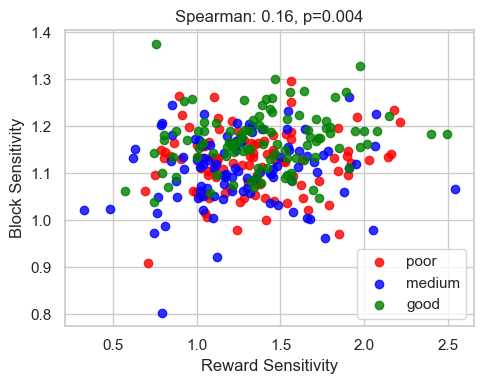

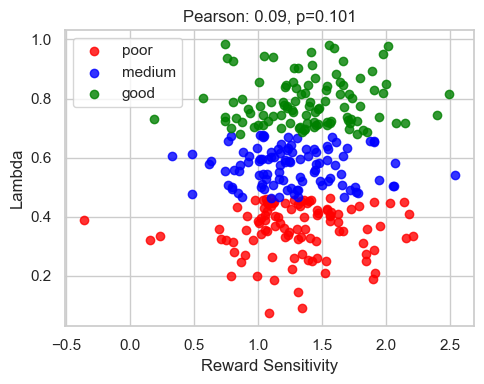

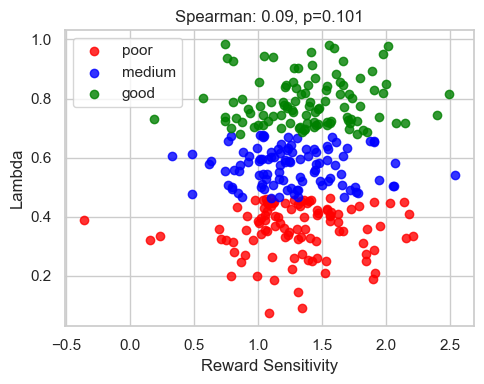

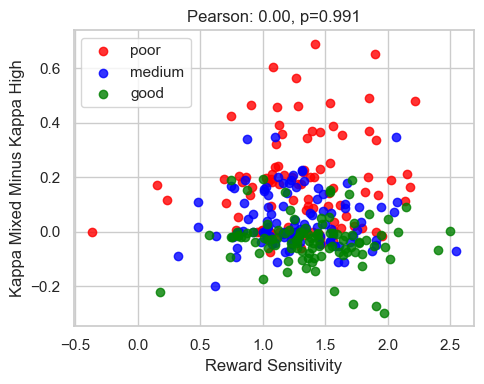

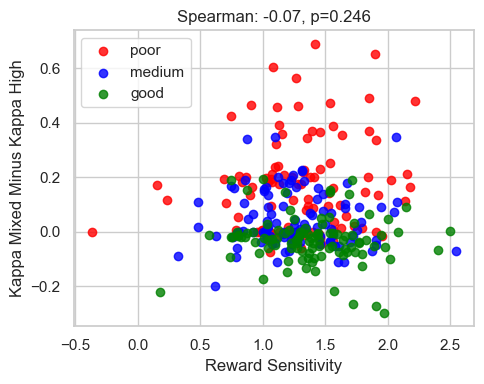

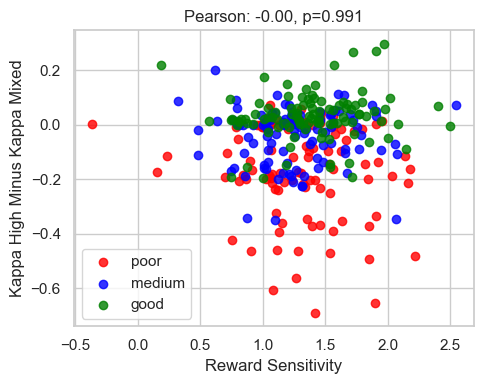

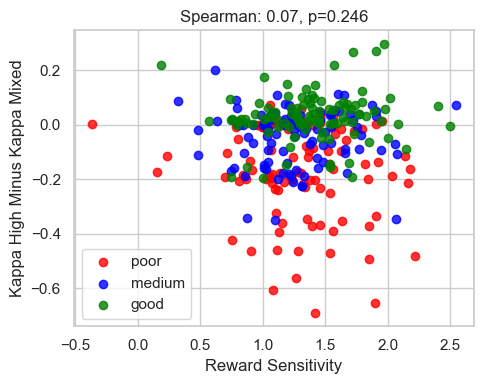

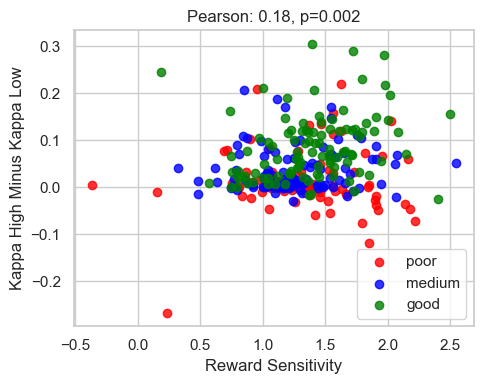

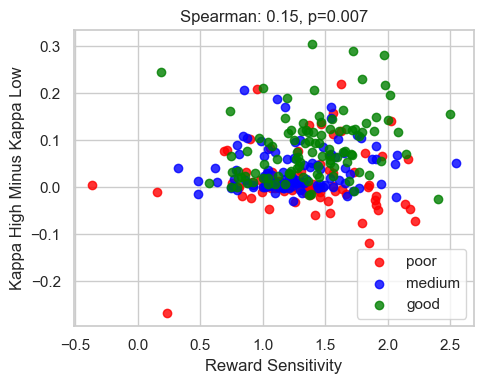

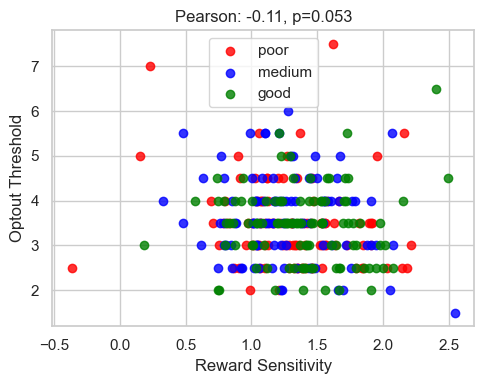

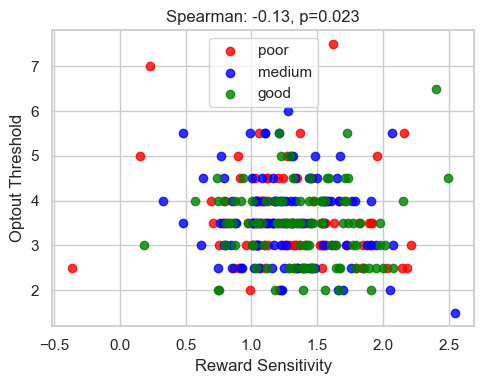

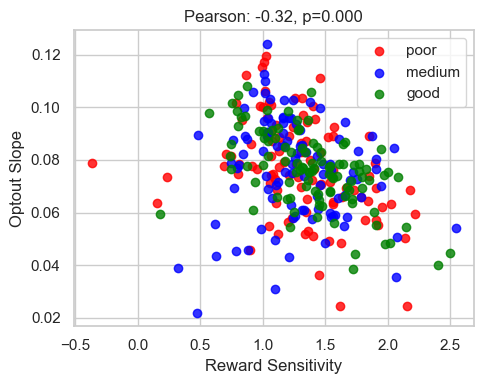

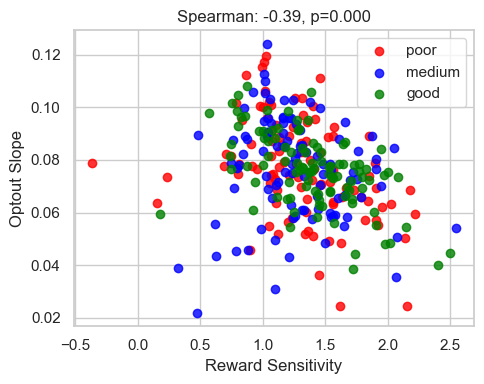

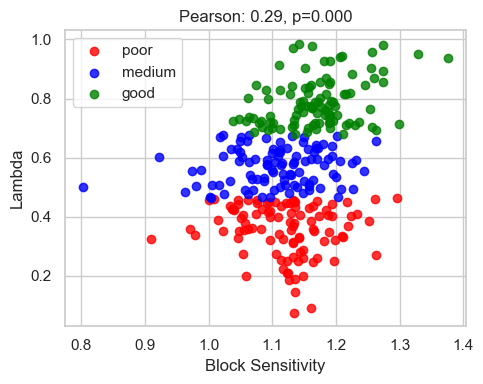

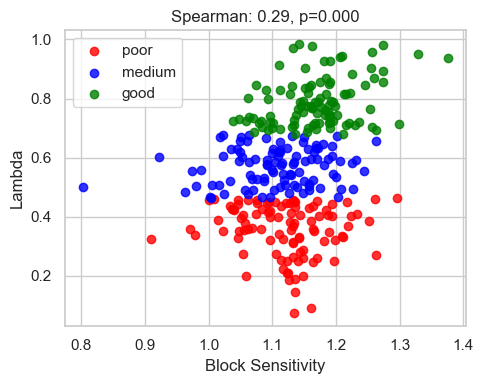

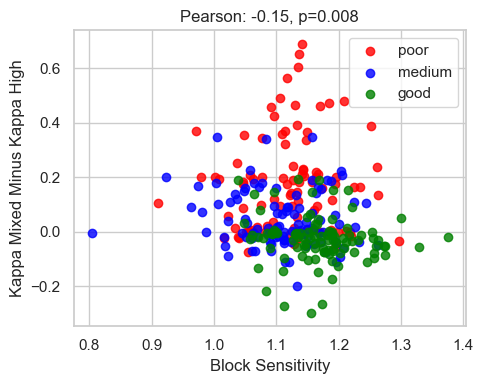

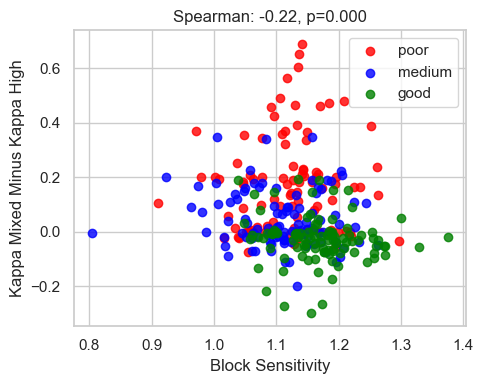

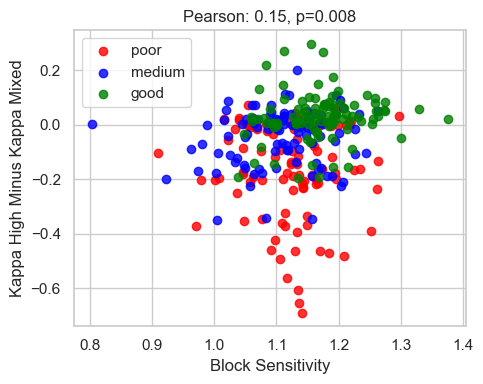

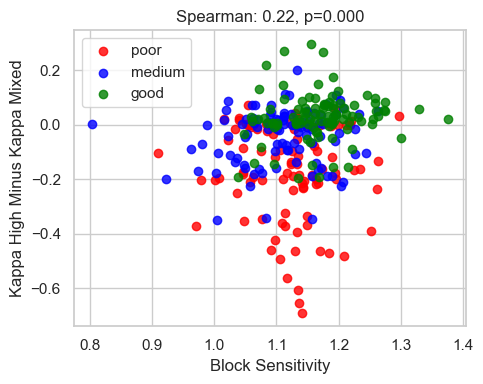

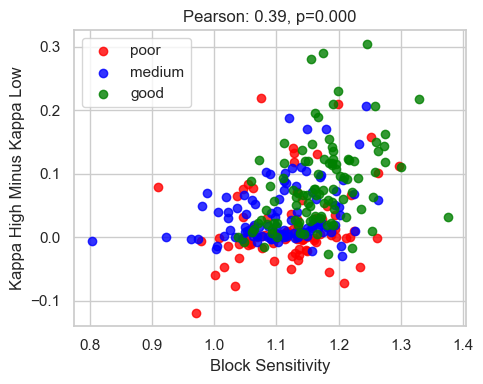

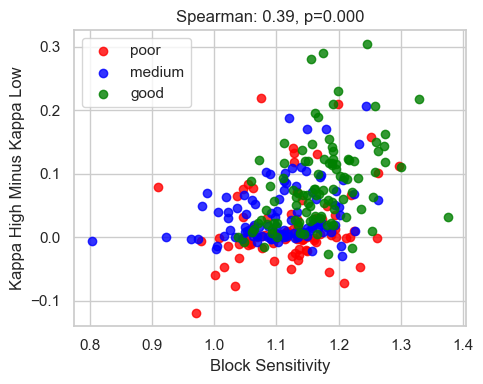

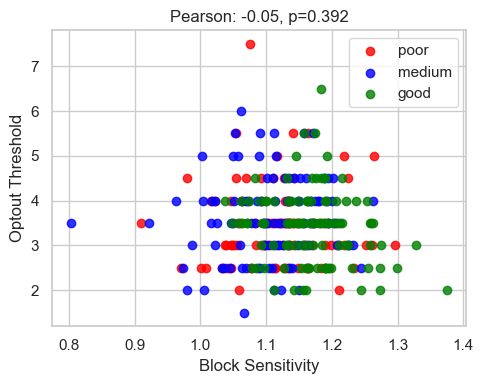

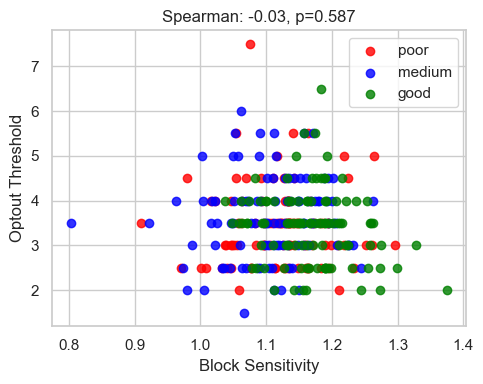

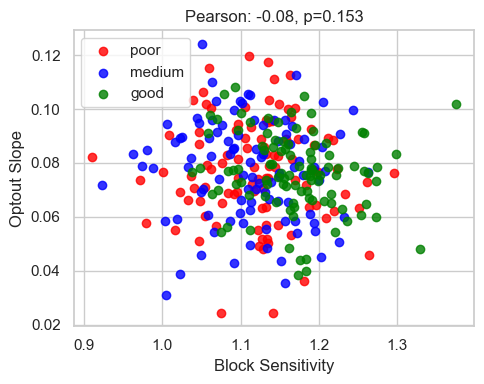

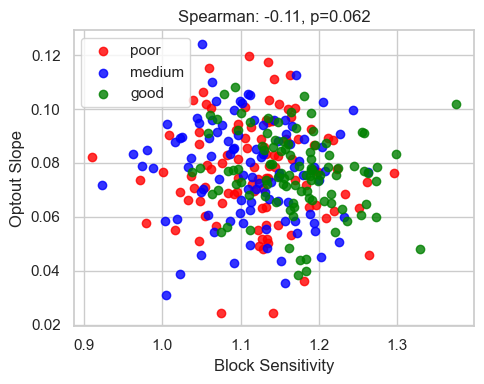

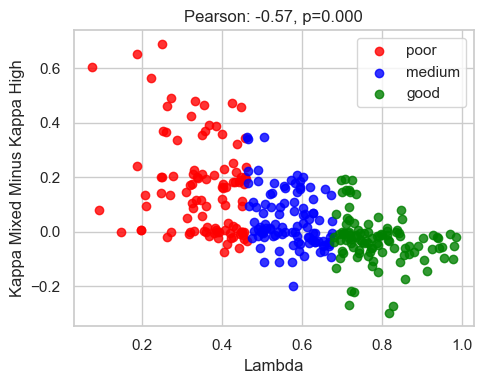

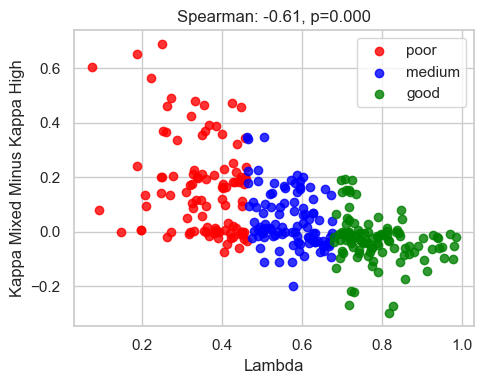

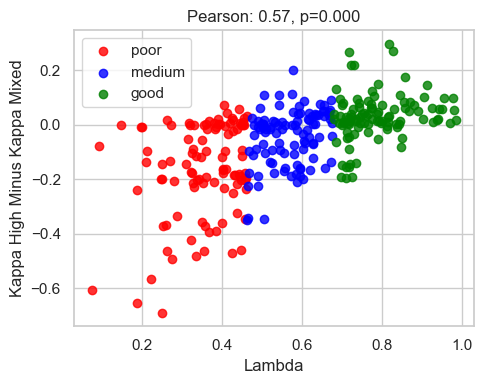

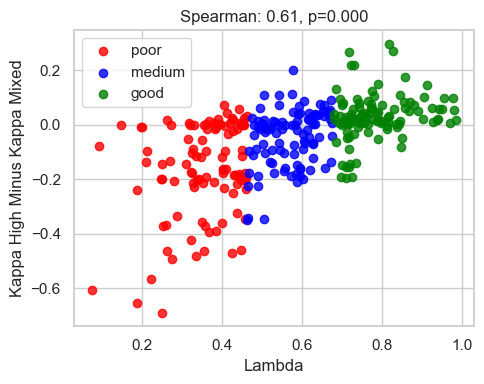

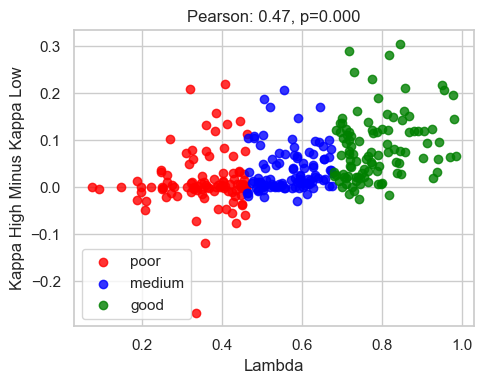

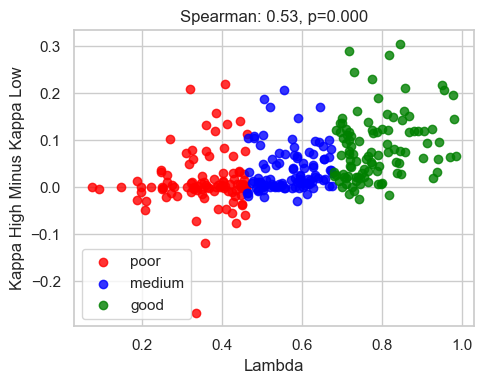

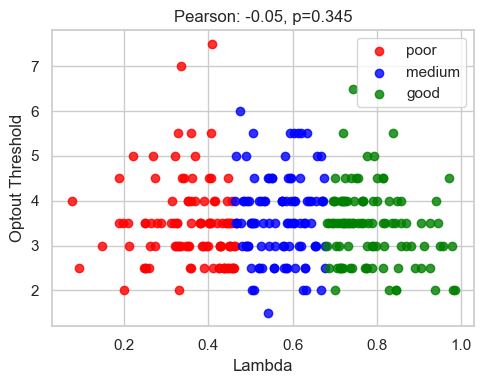

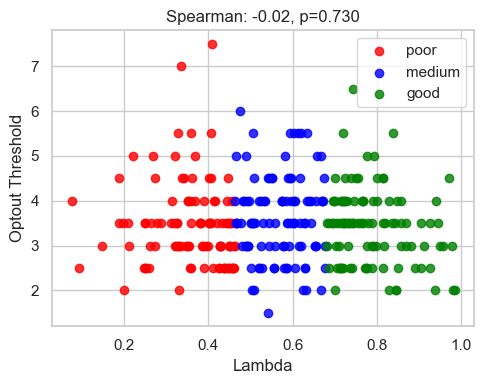

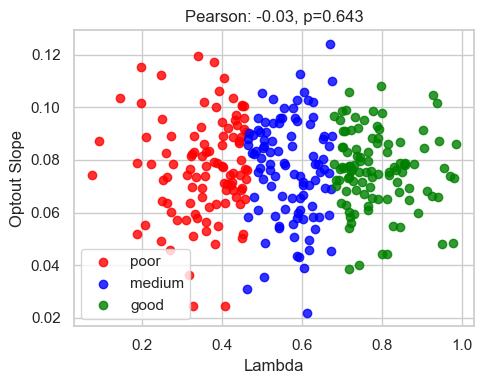

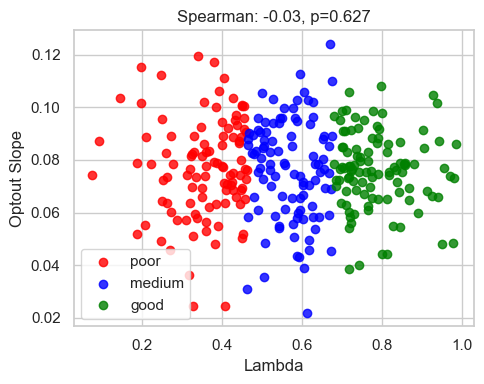

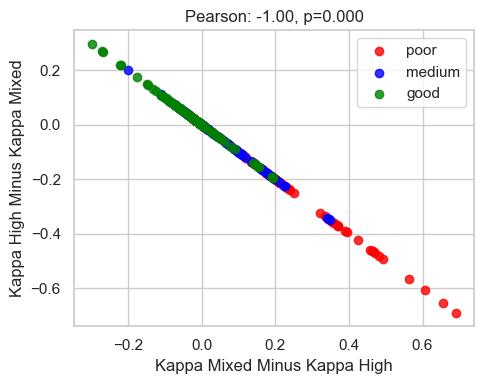

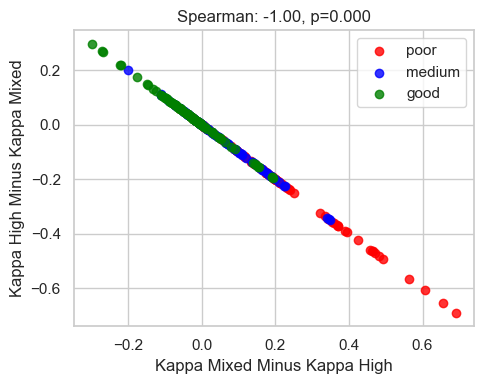

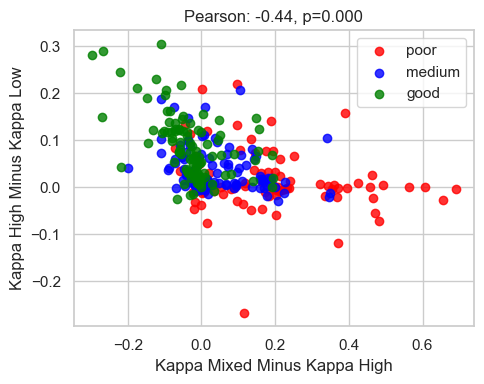

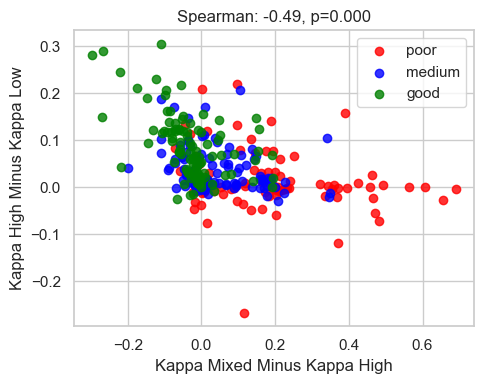

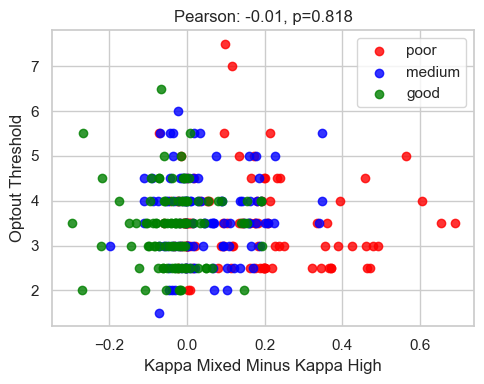

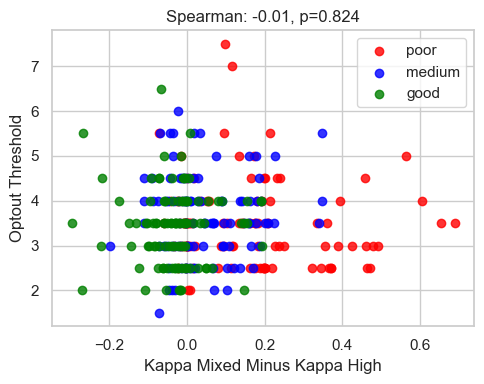

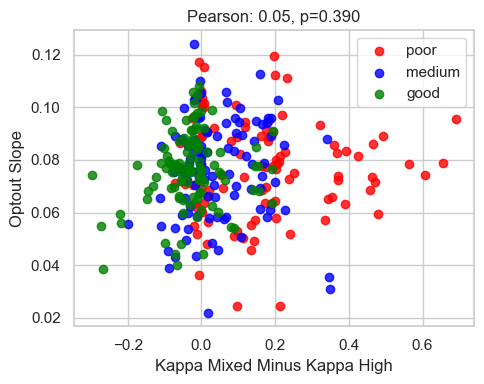

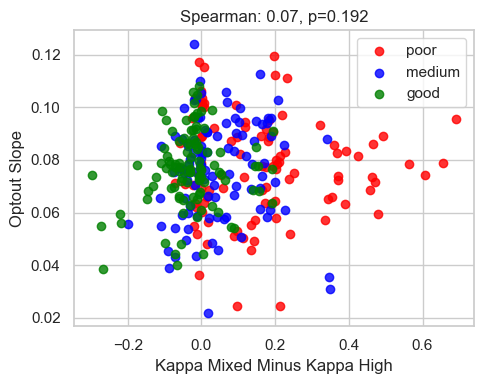

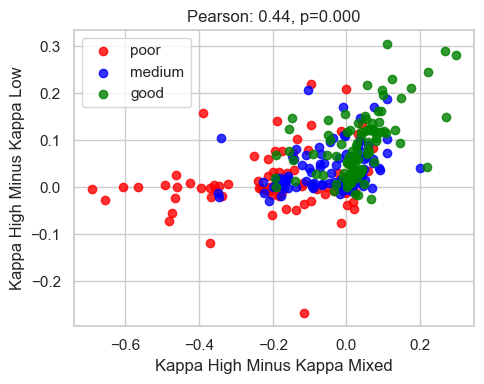

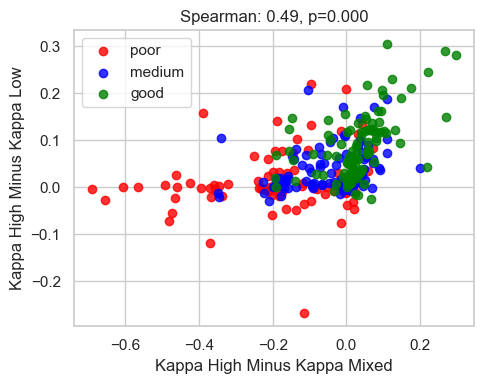

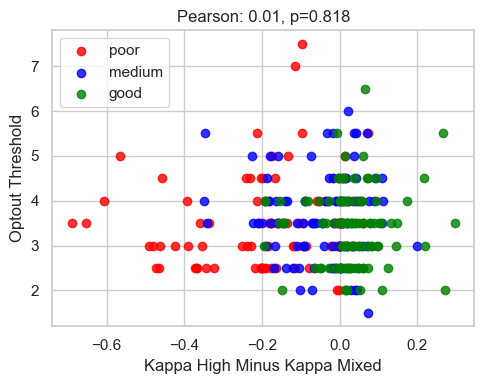

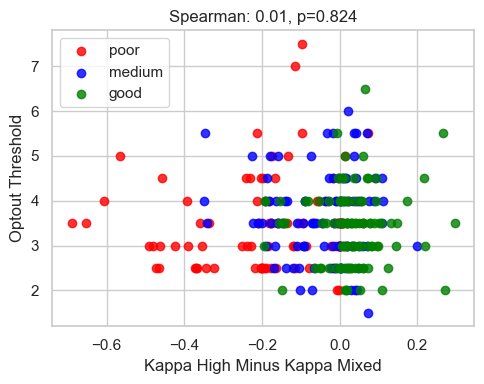

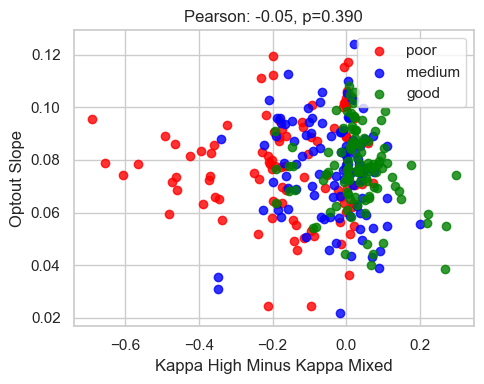

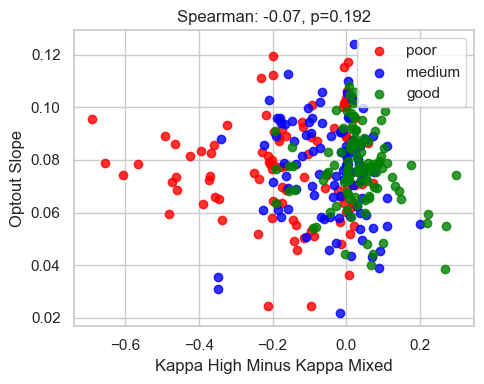

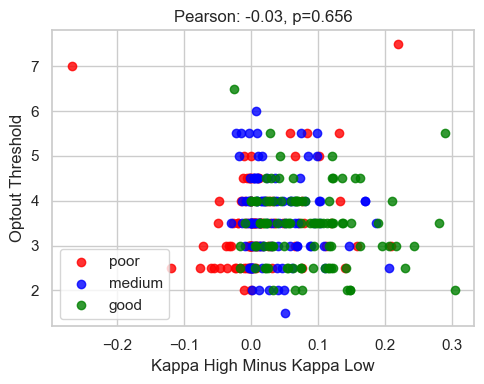

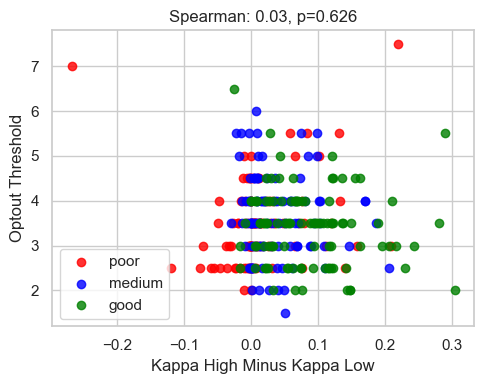

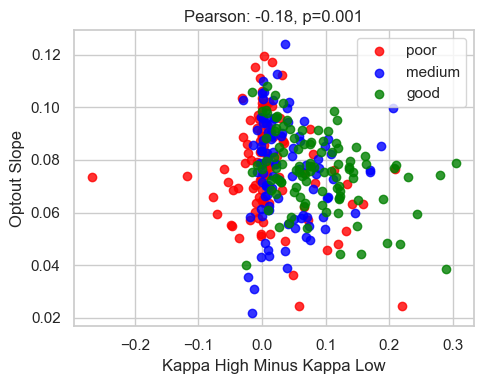

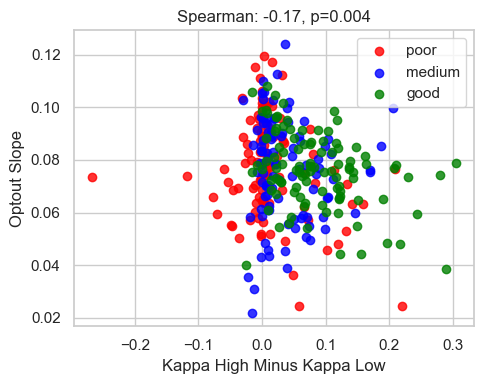

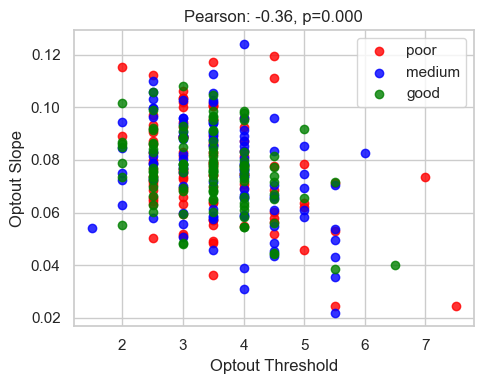

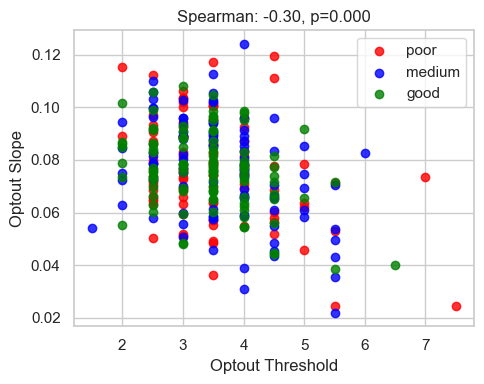

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

sns.set(style="whitegrid")
color_map = {"poor": "red", "medium": "blue", "good": "green"}

metrics = [
    "reward_sensitivity", "block_sensitivity", "lambda",
    "kappa_mixed_minus_kappa_high", "kappa_high_minus_kappa_mixed",
    "kappa_high_minus_kappa_low", "optout_threshold", "optout_slope"
]

# Loop through all unique pairs of metrics
for i, x in enumerate(metrics):
    for j, y in enumerate(metrics):
        if j <= i:
            continue

        x_vals = df[x]
        y_vals = df[y]

        # Drop NaNs from both
        valid = ~(x_vals.isna() | y_vals.isna())
        x_clean = x_vals[valid]
        y_clean = y_vals[valid]
        group_clean = df['lambda_group'][valid]

        # Pearson Plot
        pearson_corr, pearson_p = pearsonr(x_clean, y_clean)
        plt.figure(figsize=(5, 4))
        for group in ['poor', 'medium', 'good']:
            mask = group_clean == group
            plt.scatter(
                x_clean[mask], y_clean[mask],
                color=color_map[group], label=group, alpha=0.8
            )
        plt.xlabel(x.replace("_", " ").title())
        plt.ylabel(y.replace("_", " ").title())
        plt.title(f"Pearson: {pearson_corr:.2f}, p={pearson_p:.3f}")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Spearman Plot
        spearman_corr, spearman_p = spearmanr(x_clean, y_clean)
        plt.figure(figsize=(5, 4))
        for group in ['poor', 'medium', 'good']:
            mask = group_clean == group
            plt.scatter(
                x_clean[mask], y_clean[mask],
                color=color_map[group], label=group, alpha=0.8
            )
        plt.xlabel(x.replace("_", " ").title())
        plt.ylabel(y.replace("_", " ").title())
        plt.title(f"Spearman: {spearman_corr:.2f}, p={spearman_p:.3f}")
        plt.legend()
        plt.tight_layout()
        plt.show()